In [373]:
import numpy as np
import pandas as pd
from IPython.display import display


from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [374]:
dfprop=pd.read_csv(filepath_or_buffer='properati_buffered.csv',delimiter=',',index_col = 0 )

In [375]:

dfprop.drop(['cota_inf','cota_sup'],axis=1,inplace=True)

In [376]:
# Generamos una key de zona
dfprop['district_name_key']=dfprop['country_name']+"-"+\
                            dfprop['state_name']+"-"+\
                            dfprop['district_name']


## Construccion de Dummies
-  Efectuar una inspeccion de los campos title y description para indicar la existencia de palabras claves 

In [377]:
def new_dummy_from_included_in_column(dfprop_aux,column,word):
    #dfprop_aux=dfprop
    #word='POZO'
    
    #Creamos la expresion regular ..."que el texto empiece con"... word 
    re_word="("+word+")"
    
    #Creamos la expresion regular
    re_search=dfprop[column].str.extract(re_word,expand=False)
    
    #re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index
    #Creamos la columna dummy y seteamos todos los rows en 0
    dfprop_aux.loc[:,"dm_"+word]=0
    
    #Extraemos la lista de de indices donde la expresion se cumple
    prop_re_list =np.array(re_search[((re_search!=-1)&(~(pd.isna(re_search))))].index)
    
    #Actualizamos el valor de la columna Dummy a 1 en los casos dentro del indice enviado
    dfprop_aux.loc[dfprop_aux.index.isin(prop_re_list),"dm_"+word]=1
    
    return dfprop_aux

def new_dummy_from_included(dfprop_aux_,word_):
    dfprop_aux_=new_dummy_from_included_in_column(dfprop_aux_,'description',word_)
    dfprop_aux_=new_dummy_from_included_in_column(dfprop_aux_,'title',word_)
    print_dummy_count_rows(dfprop_aux_,'dm_'+word_)
    return dfprop_aux_

def print_dummy_count_rows(dfprop_aux_p,word_p):
    print('Cantidad de rows con '+word_p+": ",dfprop_aux_p.loc[dfprop_aux_p[word_p]==1,'operation'].count())
    

In [378]:
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','PH')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','apartment')
dfprop=new_dummy_from_included_in_column(dfprop,'property_type','house')

In [379]:
print_dummy_count_rows(dfprop,'dm_PH')
print_dummy_count_rows(dfprop,'dm_apartment')
print_dummy_count_rows(dfprop,'dm_house')

Cantidad de rows con dm_PH:  5099
Cantidad de rows con dm_apartment:  62525
Cantidad de rows con dm_house:  31956


In [380]:
dfprop=dfprop.loc[dfprop['price_usd_per_m2']<8000]
dfprop=dfprop.loc[dfprop['price_usd_per_m2']>1000]

In [381]:
dfprop=dfprop.loc[dfprop['state_name']=='Capital Federal',:]

In [382]:
total_district_name_key=len(dfprop['district_name_key'].unique())
i=1
for district_name_key in dfprop['district_name_key'].unique():
    print(str(i)+" de "+str(total_district_name_key)+" - Generando Dummy para localidad: "+district_name_key)
    dfprop=new_dummy_from_included_in_column(dfprop,'district_name_key',district_name_key)
    i+=1

1 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Mataderos
2 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Liniers
3 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Belgrano
4 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Palermo
5 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Flores
6 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Boedo
7 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Las Cañitas
8 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Balvanera
9 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Caballito
10 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Nuñez
11 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-San Telmo
12 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Almagro
13 de 54 - Generando Dummy para localidad: Argentina-Capital Federal-Colegial

In [383]:
column_features=[
    #'surface_total_in_m2',
'dm_house',
'dm_apartment',   
'dm_PH']

#District_key
for loc in dfprop['district_name_key'].unique():
    column_features.append('dm_'+loc)

#District_key
#for loc in dfprop['state_name'].unique():
#    column_features.append('dm_'+loc)
    
    
column_features

['dm_house',
 'dm_apartment',
 'dm_PH',
 'dm_Argentina-Capital Federal-Mataderos',
 'dm_Argentina-Capital Federal-Liniers',
 'dm_Argentina-Capital Federal-Belgrano',
 'dm_Argentina-Capital Federal-Palermo',
 'dm_Argentina-Capital Federal-Flores',
 'dm_Argentina-Capital Federal-Boedo',
 'dm_Argentina-Capital Federal-Las Cañitas',
 'dm_Argentina-Capital Federal-Balvanera',
 'dm_Argentina-Capital Federal-Caballito',
 'dm_Argentina-Capital Federal-Nuñez',
 'dm_Argentina-Capital Federal-San Telmo',
 'dm_Argentina-Capital Federal-Almagro',
 'dm_Argentina-Capital Federal-Colegiales',
 'dm_Argentina-Capital Federal-Barrio Norte',
 'dm_Argentina-Capital Federal-Barracas',
 'dm_Argentina-Capital Federal-Recoleta',
 'dm_Argentina-Capital Federal-Villa Crespo',
 'dm_Argentina-Capital Federal-Puerto Madero',
 'dm_Argentina-Capital Federal-Villa Urquiza',
 'dm_Argentina-Capital Federal-Saavedra',
 'dm_Argentina-Capital Federal-Parque Chas',
 'dm_Argentina-Capital Federal-Paternal',
 'dm_Argentina-Ca

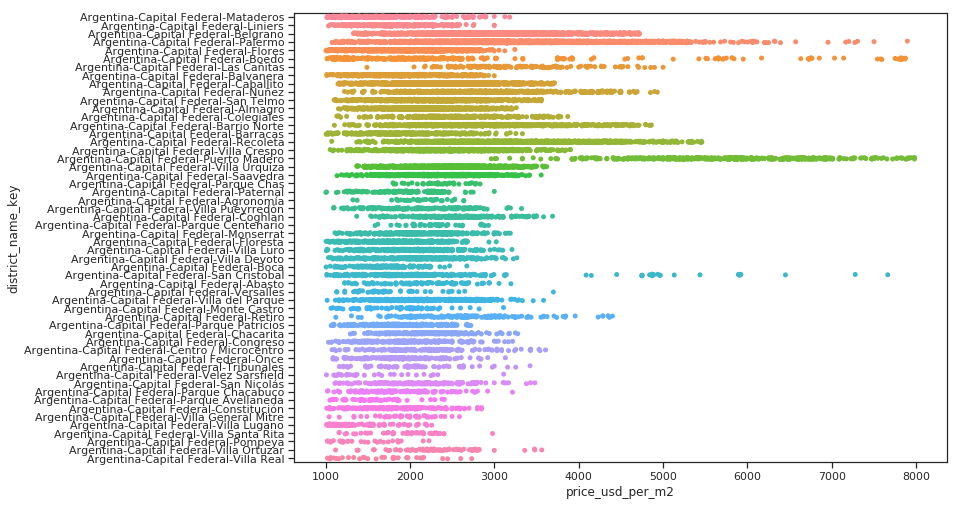

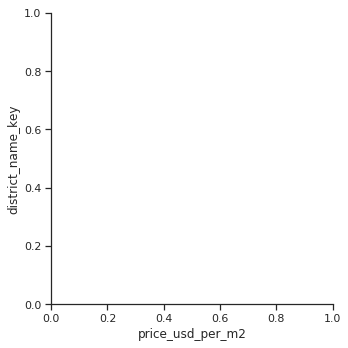

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.catplot(y="district_name_key", x="price_usd_per_m2", data=dfprop,ax=ax);

In [385]:
# Generamos una key de zona

# Agrupamos por key y sacamos precio promedio
dfprop_quartile=dfprop.groupby(by = ['district_name_key'])["price_usd_per_m2"].describe()
dfprop_quartile['district_name_key']=dfprop_quartile.index

dfprop_group_quartiles=dfprop_quartile[['25%','75%','district_name_key']]
dfprop_group_quartiles['cota_inf']=dfprop_group_quartiles['25%']-((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
dfprop_group_quartiles['cota_sup']=dfprop_group_quartiles['75%']+((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
dfprop_group_quartiles=dfprop_group_quartiles[['cota_inf','cota_sup']]
dfprop_group_quartiles
dfprop=pd.merge(dfprop,dfprop_group_quartiles,how='left',on='district_name_key')
dfprop=dfprop.loc[(dfprop['price_usd_per_m2']>dfprop['cota_inf'])&(dfprop['price_usd_per_m2']<dfprop['cota_sup'])|(dfprop['price_usd_per_m2'].isna())]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


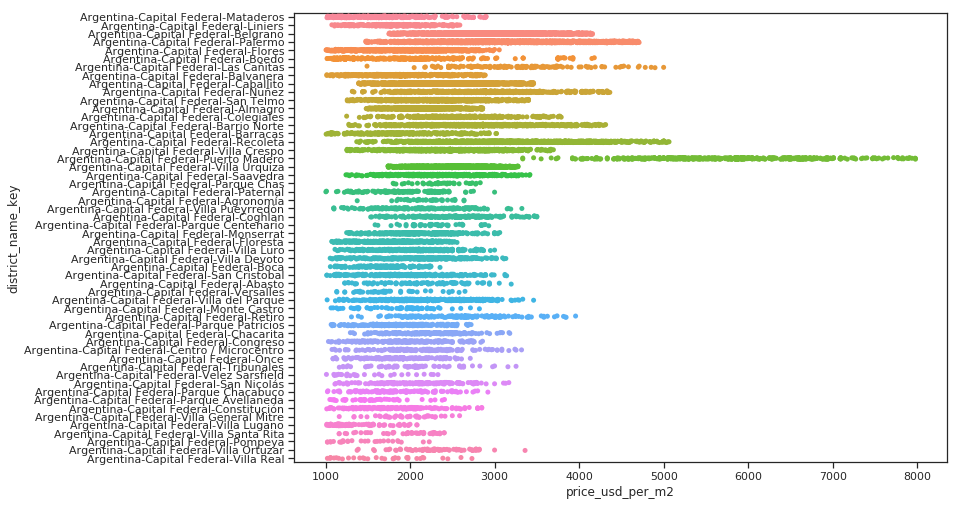

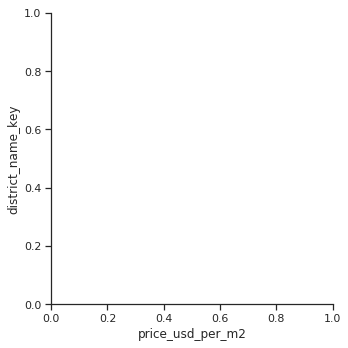

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.catplot(y="district_name_key", x="price_usd_per_m2", data=dfprop,ax=ax);

In [387]:

#SACO LOS REGISTROS EN NAN TEMPORALMENTE 
#surface_total_in_m2_not_nan=dfprop['surface_total_in_m2'].isna()

#dfprop_targets=dfprop.loc[~surface_total_in_m2_not_nan,'price_usd_per_m2']

#dfprop_features= dfprop.loc[~surface_total_in_m2_not_nan,column_features]


dfprop_targets=dfprop.loc[:,'price_usd_per_m2']

dfprop_features= dfprop.loc[:,column_features]


In [388]:
dfprop_features[dfprop_features.isnull().any(axis=1)].isna().sum()

dm_house                                             0
dm_apartment                                         0
dm_PH                                                0
dm_Argentina-Capital Federal-Mataderos               0
dm_Argentina-Capital Federal-Liniers                 0
dm_Argentina-Capital Federal-Belgrano                0
dm_Argentina-Capital Federal-Palermo                 0
dm_Argentina-Capital Federal-Flores                  0
dm_Argentina-Capital Federal-Boedo                   0
dm_Argentina-Capital Federal-Las Cañitas             0
dm_Argentina-Capital Federal-Balvanera               0
dm_Argentina-Capital Federal-Caballito               0
dm_Argentina-Capital Federal-Nuñez                   0
dm_Argentina-Capital Federal-San Telmo               0
dm_Argentina-Capital Federal-Almagro                 0
dm_Argentina-Capital Federal-Colegiales              0
dm_Argentina-Capital Federal-Barrio Norte            0
dm_Argentina-Capital Federal-Barracas                0
dm_Argenti

In [389]:
dfprop_features.shape

(26177, 57)

In [390]:
#PRIMER SEPARACION HOLDOUT - SAMPLE 100
X, X_holdout, y, y_holdout = train_test_split(dfprop_features, dfprop_targets, test_size=100, random_state=53)
print(X.shape,y.shape)
print(X_holdout.shape, y_holdout.shape)

(26077, 57) (26077,)
(100, 57) (100,)


In [391]:
#SEGUNDA SEPARACION TRAIN-TEST SPLIT
#X = PolynomialFeatures(2,include_bias=False,interaction_only=False).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18253, 57) (18253,)
(7824, 57) (7824,)


## Linear Regression

In [392]:
# en K partes para realizar la validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=12)


In [393]:
# Instanciamos los modelos

lm = LinearRegression()

# Hacemos los fits respectivos
lm.fit(X_train, y_train)

# Calculamos el R2

print(" Score Train Lineal: %.2f\n" % lm.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = lm.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm))

 Score Train Lineal: 0.66

 Train RMSE lineal   : 480.86 



## Ridge

In [394]:
al_ridge = np.linspace(0.9, 1.5, 10)
kf = KFold(n_splits=10, shuffle=True, random_state=12)
al_ridge

array([0.9       , 0.96666667, 1.03333333, 1.1       , 1.16666667,
       1.23333333, 1.3       , 1.36666667, 1.43333333, 1.5       ])

In [395]:
# Instanciamos los modelos

lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)

# Hacemos los fits respectivos
lm_ridge_cv.fit(X_train, y_train)

print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n')

Alpha Ridge: 0.9 



In [396]:
# Calculamos el R2

print("Score Train Ridge : %.4f\n" % lm_ridge_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_ridge = lm_ridge_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print("Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge))

Score Train Ridge : 0.6642

Train RMSE Ridge    : 480.83 



## LASSO

In [397]:
al_lasso = np.linspace(0.0001, 0.001, 10)
kf = KFold(n_splits=10, shuffle=True, random_state=12)
al_lasso

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ])

In [398]:
# Instanciamos los modelos

lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

# Hacemos los fits respectivos
lm_lasso_cv.fit(X_train, y_train)

print('Alpha LASSO:',lm_lasso_cv.alpha_,'\n')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Alpha LASSO: 0.00039999999999999996 



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [399]:
# Calculamos el R2
print("Score Train Lasso : %.2f\n" %  lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print("Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))

Score Train Lasso : 0.66

Train RMSE Lasso    : 480.83 



In [400]:
y_pred_lm = lm.predict(X_test)
y_pred_ridge = lm_ridge_cv.predict(X_test)
y_pred_lasso = lm_lasso_cv.predict(X_test)

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm),
      "Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridge),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lasso))

 Test RMSE lineal= 478.59
 Test RMSE Ridge = 478.74
 Test RMSE Lasso = 478.74


In [401]:
al_net =lm_lasso_cv.alpha_

In [402]:
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

enet = ElasticNet(alpha=al_net, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


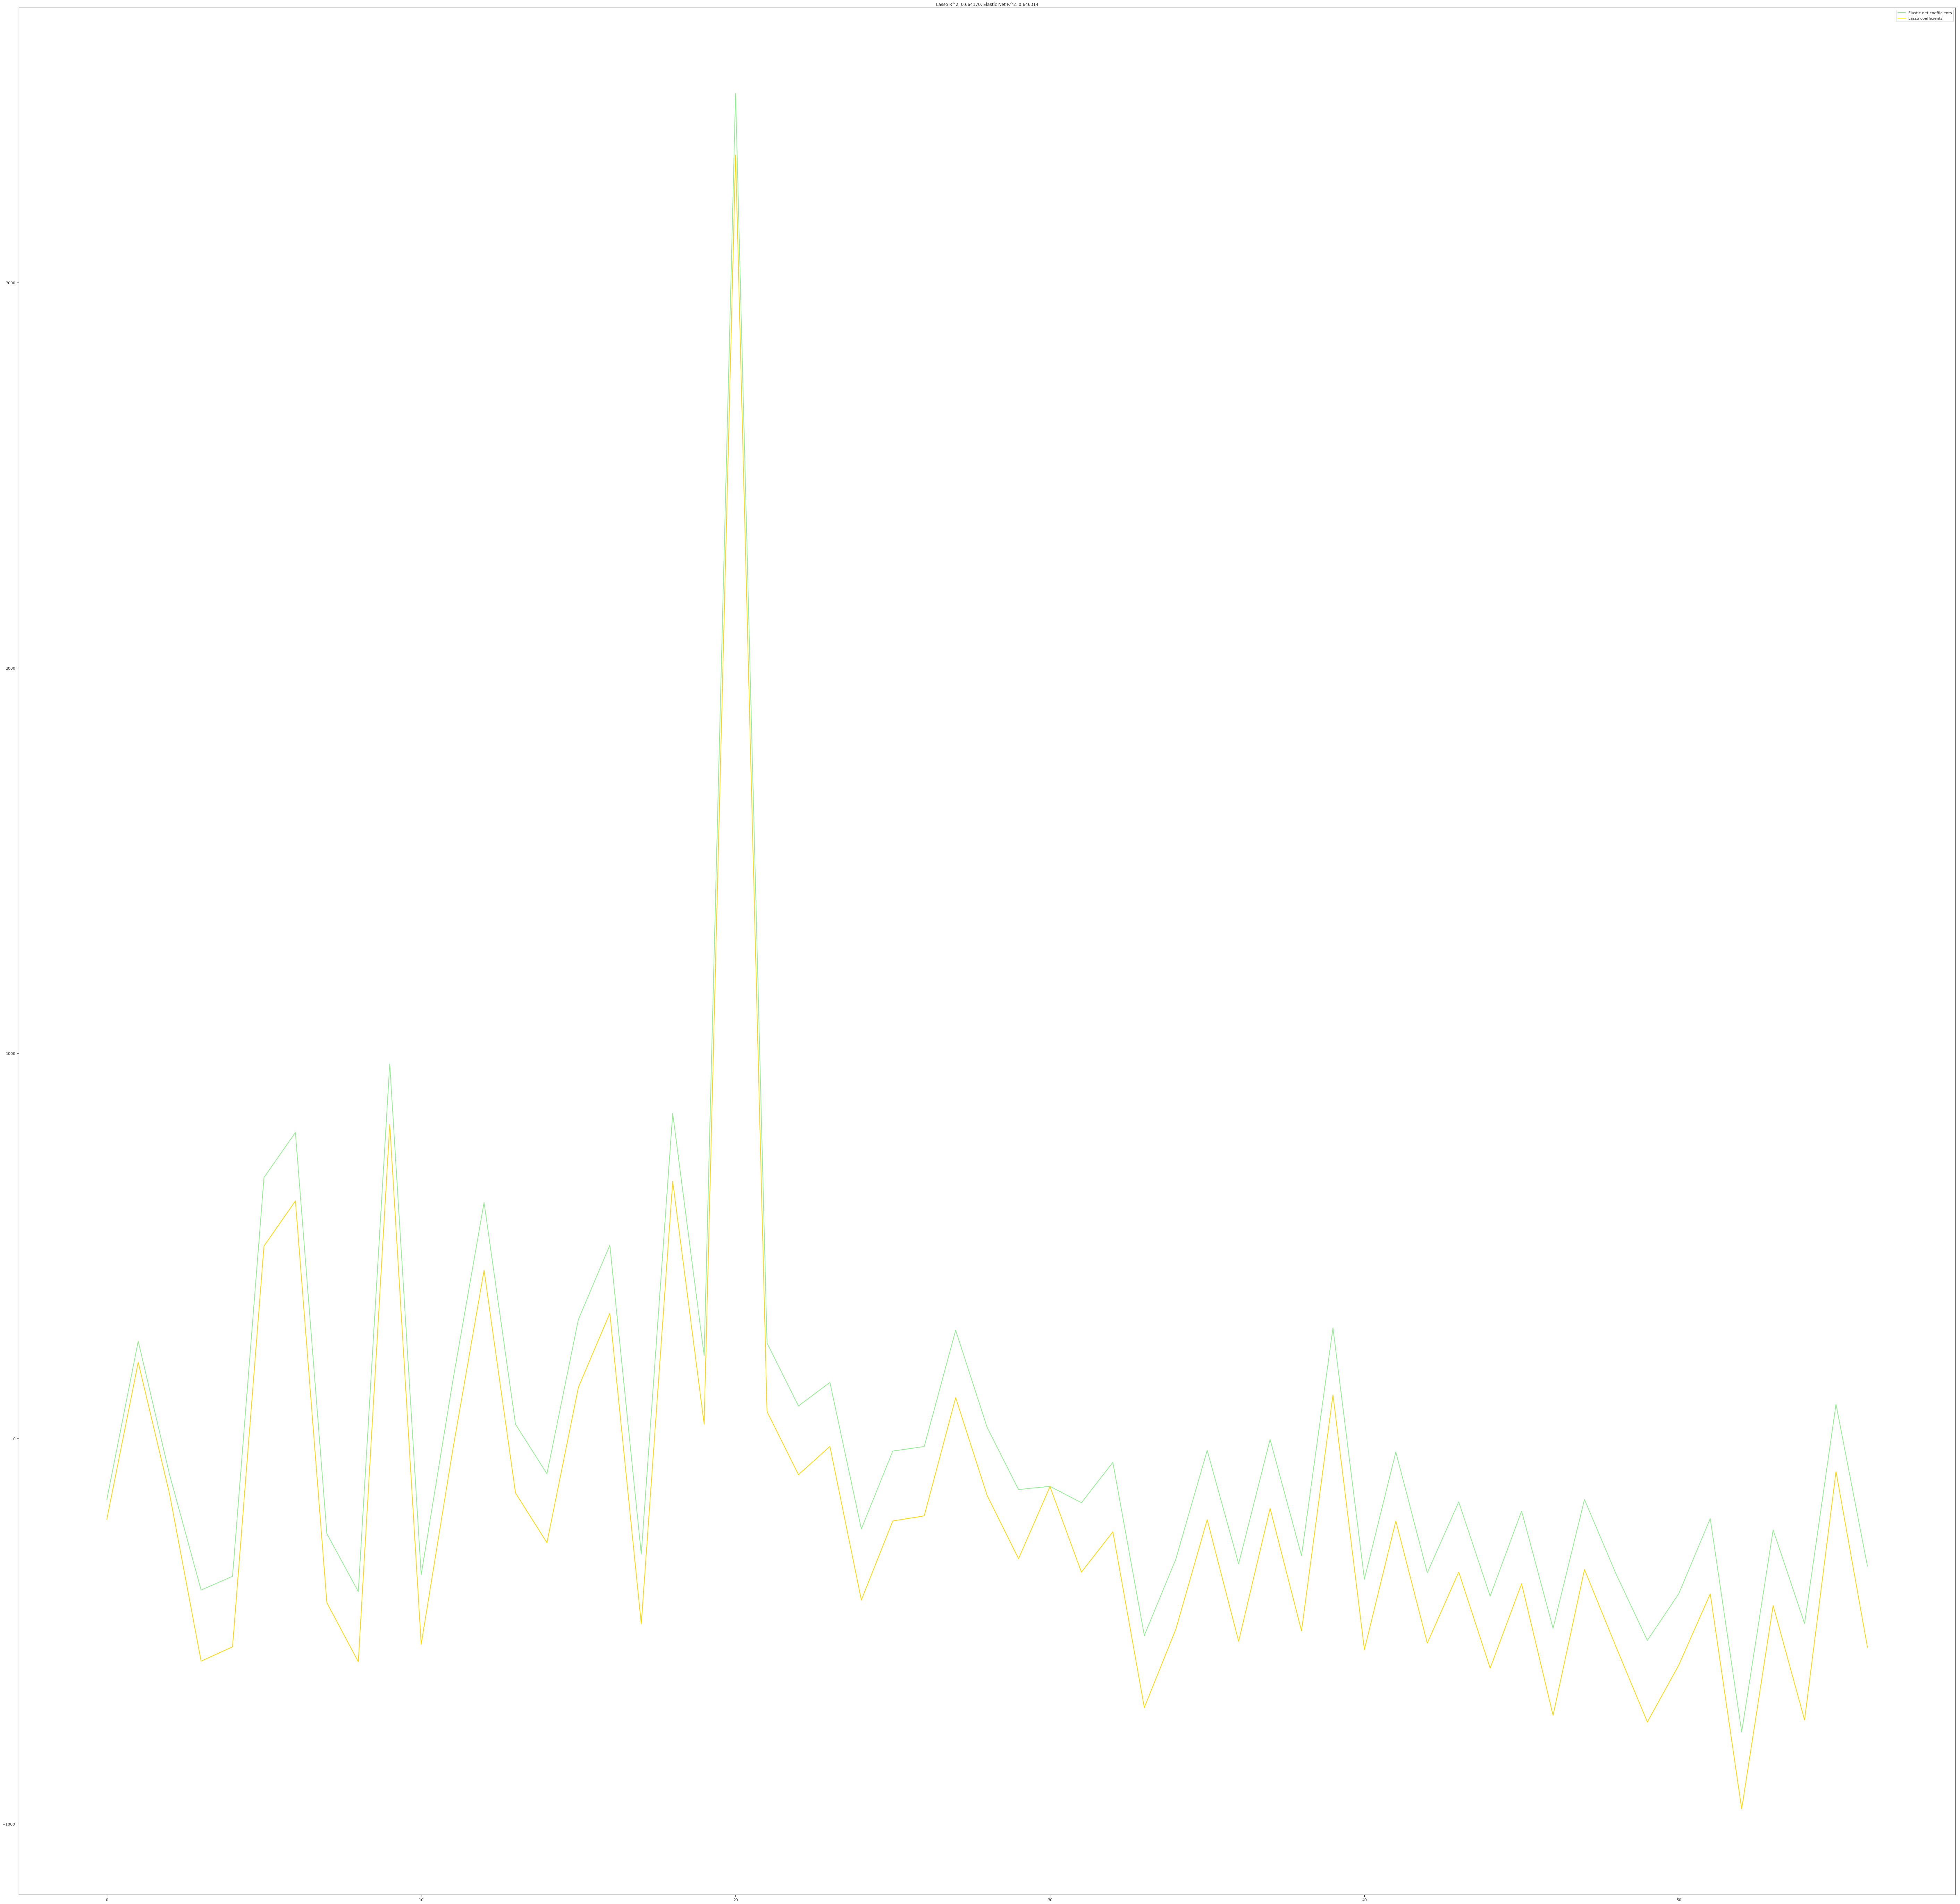

In [403]:

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lm_lasso_cv.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (lm_lasso_cv.score(X_train, y_train), r2_score_enet))
plt.show()

In [404]:
print( r2_score_enet)

0.646314394929524


In [405]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm = lm.predict(X_test)
y_pred_ridge = lm_ridge_cv.predict(X_test)
y_pred_lasso = lm_lasso_cv.predict(X_test)

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm),
      "Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridge),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lasso))



 Test RMSE lineal= 478.59
 Test RMSE Ridge = 478.74
 Test RMSE Lasso = 478.74


In [406]:
#dfprop=new_dummy_from_included(dfprop,'CONDOMINIO')
dfprop=new_dummy_from_included(dfprop,'ph')
#dfprop=new_dummy_from_included(dfprop,'QUINCHO')
#dfprop=new_dummy_from_included(dfprop,'BARRIO CERRADO')
#dfprop=new_dummy_from_included(dfprop,'BAULERA')
#dfprop=new_dummy_from_included(dfprop,'VIGILANCIA')
dfprop=new_dummy_from_included(dfprop,'OBRA')
#dfprop=new_dummy_from_included(dfprop,'PARRILLA')
#dfprop=new_dummy_from_included(dfprop,'CERRADO')
dfprop=new_dummy_from_included(dfprop,'MONOAMBIENTE')
#dfprop=new_dummy_from_included(dfprop,'ESCUELA')
#dfprop=new_dummy_from_included(dfprop,'EXPENSA')
dfprop=new_dummy_from_included(dfprop,'POZO')
dfprop=new_dummy_from_included(dfprop,'AMPLIO')
dfprop=new_dummy_from_included(dfprop,'LUMINOSO')
dfprop=new_dummy_from_included(dfprop,'PILETA')


Cantidad de rows con dm_ph:  36
Cantidad de rows con dm_OBRA:  15
Cantidad de rows con dm_MONOAMBIENTE:  511
Cantidad de rows con dm_POZO:  274
Cantidad de rows con dm_AMPLIO:  149
Cantidad de rows con dm_LUMINOSO:  390
Cantidad de rows con dm_PILETA:  31


In [113]:
"""Definimos una funcion que busque un número en una columna de un df, en base a un termino, por ejemplo: 
de '2 ambientes', con el termino 'ambientes' extraer el número '2'"""
def word_lookup(df, target_column, word):
    #importamos el modulo re que nos permite usar expresiones regulares facilmente
    import re
    #creamos una lista auxiliar
    word_list_aux = []
    #definimos el loop que analizara la columna del df
    for i in range(len(df.index)):
        if re.search(r"\d\s"+str(word), str(df[target_column].iloc[i]), flags = re.IGNORECASE):
            word_list_aux.append(float(re.search(r"\d",re.search(r"\d\s"+str(word), df[target_column].iloc[i], flags = re.IGNORECASE).group()).group()))
        else:
            word_list_aux.append(np.nan)
    return word_list_aux

In [114]:
ambientes_desc_list = word_lookup(dfprop, 'description', 'amb')

In [115]:
dfprop['ambientes_desc'] = ambientes_desc_list

In [116]:
ambientes_title_list = word_lookup(dfprop, 'title', 'amb')
dfprop['ambientes_title'] = ambientes_title_list
baño_desc_list = word_lookup(dfprop, 'description', 'baño')
bano_desc_list = word_lookup(dfprop, 'description', 'bano')
df_aux_baño = pd.DataFrame(baño_desc_list)
df_aux_bano = pd.DataFrame(bano_desc_list)
df_aux_baño = df_aux_baño.combine_first(df_aux_bano)
df_aux_baño.fillna(value = 1, inplace= True)

In [117]:
df_aux_baño.rename(mapper = {0:'baños'}, axis = 1, inplace= True)
dfprop['baños'] = df_aux_baño['baños']

In [118]:
dfprop_aux_amb = dfprop['ambientes_desc']
dfprop_aux_rooms = dfprop['rooms']
dfprop_aux_amb = dfprop_aux_amb.combine_first(dfprop_aux_rooms)
dfprop['ambientes_desc'] = dfprop_aux_amb
dfprop['ambientes_desc'] = dfprop[['ambientes_desc']].combine_first(dfprop[['ambientes_title']])

In [119]:
dfprop[['ambientes_desc','baños','price_usd_per_m2','surface_total_in_m2']]

,ambientes_desc,baños,price_usd_per_m2,surface_total_in_m2
0,2.0,1.0,1127.272727,55.0
1,NaN,1.0,1781.316254,NaN
2,2.0,1.0,1309.090909,55.0
3,3.0,1.0,1763.747254,NaN
4,NaN,1.0,1828.571429,35.0
5,NaN,1.0,1226.415094,106.0
6,NaN,1.0,3066.666667,45.0
7,NaN,1.0,3000.000000,65.0
8,NaN,1.0,677.548138,NaN
9,NaN,1.0,46.235139,1514.0


In [120]:
#dfprop_dummies_dnk = pd.get_dummies(dfprop, prefix = 'dnk', columns = 'district_name_key')
#va a faltar dropear una dummy, pero cual dropeamos?

list= dfprop['district_name_key'].unique()

In [121]:
total_localidades=len(dfprop['district_name_key'].unique())
i=1
for district_name_key in dfprop['district_name_key'].unique():
    print(str(i)+" de "+str(total_localidades)+" - Generando Dummy para localidad: "+district_name_key)
    dfprop=new_dummy_from_included_in_column(dfprop,'district_name_key',district_name_key)
    i+=1

1 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Mataderos
2 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Sur-La Plata
3 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Liniers
4 de 158 - Generando Dummy para localidad: Argentina-Buenos Aires Costa Atlántica-Mar del Plata
5 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Norte-Vicente López
6 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Belgrano
7 de 158 - Generando Dummy para localidad: Argentina-Santa Fe-Rosario
8 de 158 - Generando Dummy para localidad: Argentina-Córdoba-Córdoba
9 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Norte-San Miguel
10 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Norte-San Isidro
11 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Palermo
12 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Norte-Tigre
13 de 158 - 

100 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Once
101 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Tribunales
102 de 158 - Generando Dummy para localidad: Argentina-Buenos Aires Costa Atlántica-Santa Teresita
103 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Oeste-Hurlingham
104 de 158 - Generando Dummy para localidad: Argentina-Córdoba-Mendiolaza
105 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Sur-Esteban Echeverría
106 de 158 - Generando Dummy para localidad: Argentina-Córdoba-Río Ceballos
107 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-Velez Sarsfield
108 de 158 - Generando Dummy para localidad: Argentina-Capital Federal-San Nicolás
109 de 158 - Generando Dummy para localidad: Argentina-Bs.As. G.B.A. Zona Oeste-Marcos Paz
110 de 158 - Generando Dummy para localidad: Argentina-Mendoza-Mendoza
111 de 158 - Generando Dummy para localidad: Argentina-Córdoba-La Calera


Comprobacion (eliminar solo era comptrobar la funcion get dummies)

In [122]:
i=1
for district_name_key in dfprop['district_name_key'].unique():
    #district_name_key= dfprop['district_name_key'].unique().item(1)
    validar=dfprop['district_name_key']==district_name_key
    cantidad_df=len(dfprop.loc[validar])
    validar_dummy=dfprop['dm_'+district_name_key]==1
    cantidad_dummy=len(dfprop.loc[validar_dummy])
    print(str(i)+" - Ubicaciones para "+district_name_key+" en df= "+str(cantidad_df)+" y en dummy= "+str(cantidad_dummy)+" dif="+str(cantidad_df-cantidad_dummy)) 
    i+=1

1 - Ubicaciones para Argentina-Capital Federal-Mataderos en df= 378 y en dummy= 378 dif=0
2 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Sur-La Plata en df= 2691 y en dummy= 2691 dif=0
3 - Ubicaciones para Argentina-Capital Federal-Liniers en df= 385 y en dummy= 385 dif=0
4 - Ubicaciones para Argentina-Buenos Aires Costa Atlántica-Mar del Plata en df= 7216 y en dummy= 7216 dif=0
5 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Norte-Vicente López en df= 3456 y en dummy= 3456 dif=0
6 - Ubicaciones para Argentina-Capital Federal-Belgrano en df= 2753 y en dummy= 2753 dif=0
7 - Ubicaciones para Argentina-Santa Fe-Rosario en df= 7181 y en dummy= 7181 dif=0
8 - Ubicaciones para Argentina-Córdoba-Córdoba en df= 5652 y en dummy= 5652 dif=0
9 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Norte-San Miguel en df= 1168 y en dummy= 1168 dif=0
10 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Norte-San Isidro en df= 2827 y en dummy= 2827 dif=0
11 - Ubicaciones para Argentina-Capital Federal-P

105 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Sur-Esteban Echeverría en df= 624 y en dummy= 624 dif=0
106 - Ubicaciones para Argentina-Córdoba-Río Ceballos en df= 34 y en dummy= 34 dif=0
107 - Ubicaciones para Argentina-Capital Federal-Velez Sarsfield en df= 35 y en dummy= 35 dif=0
108 - Ubicaciones para Argentina-Capital Federal-San Nicolás en df= 162 y en dummy= 162 dif=0
109 - Ubicaciones para Argentina-Bs.As. G.B.A. Zona Oeste-Marcos Paz en df= 80 y en dummy= 80 dif=0
110 - Ubicaciones para Argentina-Mendoza-Mendoza en df= 54 y en dummy= 54 dif=0
111 - Ubicaciones para Argentina-Córdoba-La Calera en df= 108 y en dummy= 108 dif=0
112 - Ubicaciones para Argentina-Capital Federal-Parque Chacabuco en df= 132 y en dummy= 132 dif=0
113 - Ubicaciones para Argentina-Santa Fe-Santo Tomé en df= 42 y en dummy= 42 dif=0
114 - Ubicaciones para Argentina-Entre Ríos-Paraná en df= 43 y en dummy= 43 dif=0
115 - Ubicaciones para Argentina-Tucumán-San Miguel de Tucumán en df= 107 y en dummy= 10

## Regression Lineal

In [127]:
operation_type_house=dfprop['property_type']=='house'

#SACO LOS REGISTROS EN NAN TEMPORALMENTE 
surface_total_in_m2_not_nan=dfprop['surface_total_in_m2'].isna()
ambientes_desc_not_nan=dfprop['ambientes_desc'].isna()

dfprop_targets=dfprop.loc[operation_type_house&~surface_total_in_m2_not_nan&~ambientes_desc_not_nan,'price_usd_per_m2']

dfprop_features= dfprop.loc[operation_type_house&~surface_total_in_m2_not_nan&~ambientes_desc_not_nan,['price_usd_per_m2',
                                                                                                    'surface_total_in_m2',
'ambientes_desc',
'dm_CONSTRUCCION',
'dm_OBRA',
'dm_MONOAMBIENTE',
'dm_POZO',
'dm_AMPLIO',
'dm_LUMINOSO',
'dm_PILETA',
'dm_Argentina-Capital Federal-Mataderos',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-La Plata',
'dm_Argentina-Capital Federal-Liniers',
'dm_Argentina-Buenos Aires Costa Atlántica-Mar del Plata',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-Vicente López',
'dm_Argentina-Capital Federal-Belgrano',
'dm_Argentina-Santa Fe-Rosario',
'dm_Argentina-Córdoba-Córdoba',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-San Miguel',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-San Isidro',
'dm_Argentina-Capital Federal-Palermo',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-Tigre',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-General Rodríguez',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-Pilar',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Morón',
'dm_Argentina-Capital Federal-Flores',
'dm_Argentina-Capital Federal-Boedo',
'dm_Argentina-Capital Federal-Las Cañitas',
'dm_Argentina-Córdoba-Villa Carlos Paz',
'dm_Argentina-Capital Federal-Balvanera',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-Escobar',
'dm_Argentina-Capital Federal-Caballito',
'dm_Argentina-Capital Federal-Nuñez',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Berazategui',
'dm_Argentina-Misiones-Posadas',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Tres de Febrero',
'dm_Argentina-Buenos Aires Costa Atlántica-San Bernardo',
'dm_Argentina-Capital Federal-San Telmo',
'dm_Argentina-Capital Federal-Almagro',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-San Fernando',
'dm_Argentina-Buenos Aires Costa Atlántica-Pinamar',
'dm_Argentina-Entre Ríos-Colón',
'dm_Argentina-Buenos Aires Interior-Luján',
'dm_Argentina-Santa Fe-San Lorenzo',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Lanús',
'dm_Argentina-Córdoba-Punilla',
'dm_Argentina-Buenos Aires Costa Atlántica-Villa Gesell',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Lomas de Zamora',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-General San Martín',
'dm_Argentina-Capital Federal-Colegiales',
'dm_Argentina-Santa Fe-Santa Fe',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Quilmes',
'dm_Argentina-Neuquén-Confluencia',
'dm_Argentina-Capital Federal-Barrio Norte',
'dm_Argentina-Capital Federal-Barracas',
'dm_Argentina-Córdoba-Villa Allende',
'dm_Argentina-Buenos Aires Interior-Lobos',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-La Matanza',
'dm_Argentina-Neuquén-San Martín de los Andes',
'dm_Argentina-Capital Federal-Recoleta',
'dm_Argentina-Capital Federal-Villa Crespo',
'dm_Argentina-Capital Federal-Puerto Madero',
'dm_Argentina-Capital Federal-Constitución',
'dm_Argentina-Capital Federal-Villa Urquiza',
'dm_Argentina-San Luis-Merlo',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-José C Paz',
'dm_Argentina-Capital Federal-Saavedra',
'dm_Argentina-Buenos Aires Interior-Bahía Blanca',
'dm_Argentina-Río Negro-General Roca',
'dm_Argentina-Neuquén-Neuquén',
'dm_Argentina-Capital Federal-Parque Chas',
'dm_Argentina-Capital Federal-Paternal',
'dm_Argentina-Capital Federal-Agronomía',
'dm_Argentina-Capital Federal-Villa Pueyrredón',
'dm_Argentina-Capital Federal-Coghlan',
'dm_Argentina-Capital Federal-Parque Centenario',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Moreno',
'dm_Argentina-Capital Federal-Monserrat',
'dm_Argentina-Capital Federal-Floresta',
'dm_Argentina-Capital Federal-Villa Luro',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Almirante Brown',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Ituzaingó',
'dm_Argentina-Capital Federal-Villa Devoto',
'dm_Argentina-Capital Federal-Boca',
'dm_Argentina-Buenos Aires Interior-Rivadavia',
'dm_Argentina-Capital Federal-Parque Avellaneda',
'dm_Argentina-Bs.As. G.B.A. Zona Norte-Malvinas Argentinas',
'dm_Argentina-Capital Federal-San Cristobal',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Cañuelas',
'dm_Argentina-Salta-Salta',
'dm_Argentina-Capital Federal-Abasto',
'dm_Argentina-Capital Federal-Versalles',
'dm_Argentina-Capital Federal-Villa del Parque',
'dm_Argentina-Capital Federal-Monte Castro',
'dm_Argentina-Capital Federal-Retiro',
'dm_Argentina-Capital Federal-Parque Patricios',
'dm_Argentina-Buenos Aires Interior-General Pueyrredón',
'dm_Argentina-Río Negro-San Carlos de Bariloche',
'dm_Argentina-Capital Federal-Chacarita',
'dm_Argentina-Capital Federal-Congreso',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Merlo',
'dm_Argentina-Buenos Aires Interior-Tres Arroyos',
'dm_Argentina-Santa Fe-Granadero Baigorria',
'dm_Argentina-Santa Fe-Funes',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Ezeiza',
'dm_Argentina-Capital Federal-Centro / Microcentro',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Avellaneda',
'dm_Argentina-Buenos Aires Interior-Chascomús',
'dm_Argentina-Buenos Aires Costa Atlántica-Mar de Ajó',
'dm_Argentina-Capital Federal-Once',
'dm_Argentina-Capital Federal-Tribunales',
'dm_Argentina-Buenos Aires Costa Atlántica-Santa Teresita',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Hurlingham',
'dm_Argentina-Córdoba-Mendiolaza',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Esteban Echeverría',
'dm_Argentina-Córdoba-Río Ceballos',
'dm_Argentina-Capital Federal-Velez Sarsfield',
'dm_Argentina-Capital Federal-San Nicolás',
'dm_Argentina-Bs.As. G.B.A. Zona Oeste-Marcos Paz',
'dm_Argentina-Mendoza-Mendoza',
'dm_Argentina-Córdoba-La Calera',
'dm_Argentina-Capital Federal-Parque Chacabuco',
'dm_Argentina-Santa Fe-Santo Tomé',
'dm_Argentina-Entre Ríos-Paraná',
'dm_Argentina-Tucumán-San Miguel de Tucumán',
'dm_Argentina-Buenos Aires Costa Atlántica-Miramar',
'dm_Argentina-Buenos Aires Interior-Trenque Lauquen',
'dm_Argentina-Santa Fe-Roldán',
'dm_Argentina-Buenos Aires Costa Atlántica-Costa Esmeralda',
'dm_Argentina-Corrientes-Ituzaingó',
'dm_Argentina-Buenos Aires Interior-Tandil',
'dm_Argentina-Mendoza-San Rafael',
'dm_Argentina-Buenos Aires Interior-San Pedro',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Presidente Perón',
'dm_Argentina-Buenos Aires Costa Atlántica-Mar Azul',
'dm_Argentina-San Luis-San Luis',
'dm_Argentina-Buenos Aires Costa Atlántica-Valeria del Mar',
'dm_Argentina-Capital Federal-Pompeya',
'dm_Argentina-Capital Federal-Villa General Mitre',
'dm_Argentina-Córdoba-Río Cuarto',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-San Vicente',
'dm_Argentina-Buenos Aires Interior-Coronel Suárez',
'dm_Argentina-Buenos Aires Interior-San Miguel del Monte',
'dm_Argentina-Neuquén-Lácar',
'dm_Argentina-Capital Federal-Villa Lugano',
'dm_Argentina-Buenos Aires Costa Atlántica-Monte Hermoso',
'dm_Argentina-Tucumán-Yerba Buena',
'dm_Argentina-Bs.As. G.B.A. Zona Sur-Florencio Varela',
'dm_Argentina-Buenos Aires Costa Atlántica-Cariló',
'dm_Argentina-Capital Federal-Villa Santa Rita',
'dm_Argentina-Capital Federal-Villa Ortuzar',
'dm_Argentina-Córdoba-Santa María',
'dm_Argentina-Córdoba-Villa General Belgrano',
'dm_Argentina-Córdoba-Unquillo',
'dm_Argentina-Buenos Aires Costa Atlántica-Mar de las Pampas',
'dm_Argentina-Capital Federal-Villa Real',
'dm_Argentina-Córdoba-San Roque',
'dm_Argentina-Neuquén-Villa La Angostura',
'dm_Argentina-Santa Fe-Capitán Bermúdez',
'dm_Argentina-Buenos Aires Interior-Balcarce',
'dm_Argentina-Córdoba-Santa Rosa de Calamuchita',
'dm_Argentina-Santa Fe-Rafaela',
'dm_Argentina-Entre Ríos-Villa Urquiza',
'dm_Argentina-Chubut-Escalante',
'dm_Argentina-Chubut-Cushamen',
'dm_Argentina-Mendoza-San Roque',
'dm_Argentina-Corrientes-Mburucuyá',
'dm_Argentina-Córdoba-Malvinas Argentinas'
]]

dfprop_features=dfprop_features.drop(columns=['dm_Argentina-Capital Federal-Las Cañitas',
                              'dm_Argentina-Capital Federal-Parque Centenario',
                              'dm_Argentina-Buenos Aires Interior-Rivadavia',
                              'dm_Argentina-Capital Federal-Retiro',
                              'dm_Argentina-Capital Federal-Once',
                              'dm_Argentina-Capital Federal-Tribunales',
                              'dm_Argentina-Entre Ríos-Paraná',
                              'dm_Argentina-Santa Fe-Rafaela',
                              'dm_Argentina-Chubut-Escalante',
                              'dm_Argentina-Mendoza-San Roque',
                              'dm_Argentina-Corrientes-Mburucuyá'])

In [128]:
dfprop_features[dfprop_features.isnull().any(axis=1)].isna().sum()

price_usd_per_m2                                               0
surface_total_in_m2                                            0
ambientes_desc                                                 0
dm_CONSTRUCCION                                                0
dm_OBRA                                                        0
dm_MONOAMBIENTE                                                0
dm_POZO                                                        0
dm_AMPLIO                                                      0
dm_LUMINOSO                                                    0
dm_PILETA                                                      0
dm_Argentina-Capital Federal-Mataderos                         0
dm_Argentina-Bs.As. G.B.A. Zona Sur-La Plata                   0
dm_Argentina-Capital Federal-Liniers                           0
dm_Argentina-Buenos Aires Costa Atlántica-Mar del Plata        0
dm_Argentina-Bs.As. G.B.A. Zona Norte-Vicente López            0
dm_Argentina-Capital Fede

In [129]:
zero_variables = dfprop_features.sum()==0
zero_variables.loc[zero_variables==True]

Series([], dtype: bool)

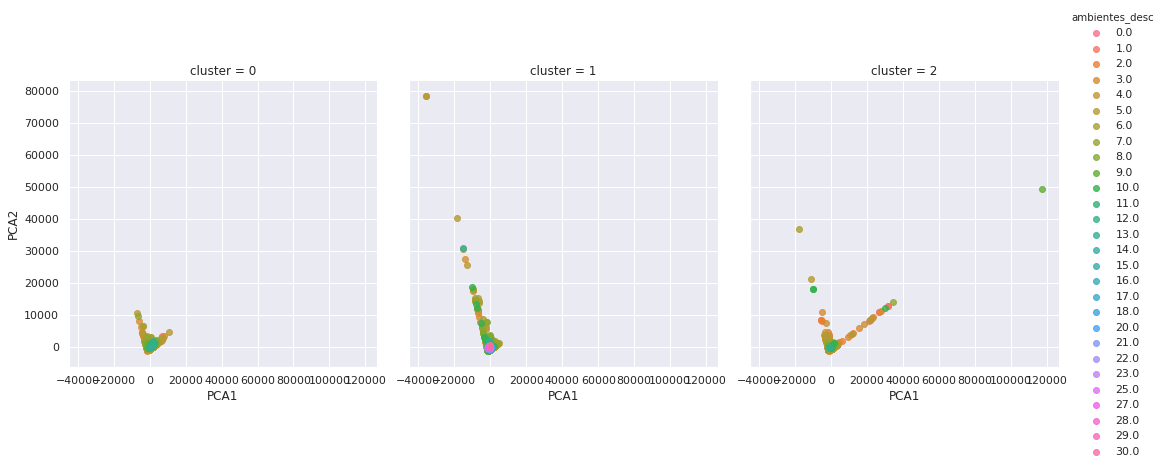

In [132]:
# Generamos la matriz de las features:
X_features = dfprop_features.drop('ambientes_desc', axis=1)
X_features.shape

# 1. Seleccionar la clase de modelo
from sklearn.decomposition import PCA  

# 2. Instanciar el modelo con hiperparámetros
model = PCA(n_components=2)            

# 3. Ajustar a los datos. Notar que no especificamos "y" 
model.fit(X_features)                      

# 4. Transformar los datos a dos dimensiones
X_2D = model.transform(X_features)  
model.components_

dfprop_features['PCA1'] = X_2D[:, 0]
dfprop_features['PCA2'] = X_2D[:, 1]

# 1. Elegimos la clase de modelo
from sklearn.mixture import GaussianMixture

# 2. Instanciamos el modelo con sus hiperparámetros
model = GaussianMixture(n_components=3,
            covariance_type='full')  

# 3. Ajustamos a los datos. Notar que "y" no es especificada
model.fit(X_features)                    

# 4. Determinamos las etiquetas de los clusters
y_gmm = model.predict(X_features)    


dfprop_features['cluster'] = y_gmm

sns.lmplot("PCA1", "PCA2", data=dfprop_features, hue='ambientes_desc',col='cluster', fit_reg=False);

In [32]:
#PRIMER SEPARACION HOLDOUT - SAMPLE 100
X, X_holdout, y, y_holdout = train_test_split(dfprop_features, dfprop_targets, test_size=100, random_state=53)
print(X.shape,y.shape)
print(X_holdout.shape, y_holdout.shape)


(93181, 162) (93181,)
(100, 162) (100,)


In [33]:
#SEGUNDA SEPARACION TRAIN-TEST SPLIT
#X = PolynomialFeatures(2,include_bias=False,interaction_only=False).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(65226, 162) (65226,)
(27955, 162) (27955,)


In [42]:
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(1,2, 10)
#al_lasso = np.linspace(0.01, 0.6, 10)
kf = KFold(n_splits=10, shuffle=True, random_state=12)
al_ridge

array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ])

In [43]:
# Instanciamos los modelos

#lm = LinearRegression()
lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
#lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

# Hacemos los fits respectivos
#lm.fit(X_train, y_train)
lm_ridge_cv.fit(X_train, y_train)
#lm_lasso_cv.fit(X_train, y_train)

print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n')
#print('Alpha LASSO:',lm_lasso_cv.alpha_,'\n')

Alpha Ridge: 1.8888888888888888 



In [43]:
len(lm_lasso_cv.coef_)
(lm_lasso_cv.intercept_,lm_lasso_cv.coef_)

(1374.9417803412618,
 array([ -0.21120407, -26.47442422,   0.        , ...,   0.        ,
          0.        ,  -0.        ]))

In [44]:
# Calculamos el R2

#print(" Score Train Lineal: %.2f\n" % lm.score(X_train, y_train))
print("Score Train Ridge : %.2f\n" % lm_ridge_cv.score(X_train, y_train))
#print("Score Train Lasso : %.2f\n" %  lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

#y_pred_tr_lm = lm.predict(X_train)
y_pred_tr_ridge = lm_ridge_cv.predict(X_train)
#y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

#print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm))
print("Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge))
#print("Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))

Score Train Ridge : 0.47

Train RMSE Ridge    : 1244.57 



In [38]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,2)})
sns.heatmap(pd.concat([dfprop_features, pd.DataFrame(y, columns=['target'])], axis=1).corr().iloc[[-1]], annot=True);